In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier,plot_tree
from collections import Counter

In [ ]:
class DT:
    def __init__(self,max_depth=5,min_samples_split=2,device="cuda"):
        self.max_depth=max_depth
        self.min_samples_split=min_samples_split
        self.device=torch.device(device if torch.cuda.is_available() else "cpu")
        self.tree=None
    
    def gini_impurity(self,y):
        unique_classes,counts=torch.unique(y,return_counts=True)
        pi=counts.float()/counts.sum()
        return 1-torch.sum(pi**2)
    
    def best_split(self,x,y):
        m,n=x.shape

        best_gini,best_feature,best_cut=torch.inf,None,None

        for feature in range(n):
            thresholds=torch.unique(x[:,feature])
            for threshold in thresholds:
                left_part=x[:,feature]<threshold
                right_part=(x[:,feature]>=threshold)

                if torch.sum(left_part)<self.min_samples_split or torch.sum(right_part)<self.min_samples_split:
                    continue

                gini_left=self.gini_impurity(y[left_part])
                gini_right=self.gini_impurity(y[right_part])
                
                gini=(torch.sum(left_part)*gini_left+torch.sum(right_part)*gini_right)/m

                if gini<best_gini:
                    best_gini,best_feature,best_cut=gini,feature,threshold

        return best_feature,best_cut
    
    def split(self,x,y,feature,threshold):
        left_part=x[:,feature]<threshold
        right_part=(x[:,feature]>=threshold)

        return x[left_part],y[left_part],x[right_part],y[right_part]
    
    def build_tree(self,x,y,depth=0):
        if depth>=self.max_depth or len(torch.unique(y))==1 or len(y)<self.min_samples_split:
            return torch.mode(y)[0].item()

        feature,threshold=self.best_split(x,y)
        if feature is None:
            return torch.mode(y)[0].item()

        x_left,y_left,x_right,y_right=self.split(x,y,feature,threshold)
        return {"feature": feature,"threshold": threshold.item(),"left": self.build_tree(x_left,y_left,depth+1),"right": self.build_tree(x_right,y_right,depth+1)
    }

    def predict_sample(self,x,node):
        if isinstance(node,dict):
            if x[node["feature"]]<node["threshold"]:
                return self.predict_sample(x,node["left"])
            else:
                return self.predict_sample(x,node["right"])
        return node
    
    def predict_proba(self,x):
        x_torch=torch.tensor(x,dtype=torch.float32,device=self.device)
        probas=[]
        for sample in x_torch:
            predicted_class=self.predict_sample(sample, self.tree)
            res_probs=[0.0,0.0,0.0]
            res_probs[predicted_class]=1.0
            probas.append(res_probs)
        return torch.tensor(probas,device=self.device).cpu().numpy()
    
    def predict(self,x):
        x_torch=torch.tensor(x,dtype=torch.float32,device=self.device)
        return torch.tensor([self.predict_sample(x, self.tree) for x in x_torch],device=self.device)

    
    def plot_sklearn_tree(x,y,feature_names):
        clf=DecisionTreeClassifier(max_depth=3)
        clf.fit(x,y)

        plt.figure(figsize=(13,7))
        plot_tree(clf,feature_names=feature_names,class_names=["No Diabetes","Prediabetes","Diabetes"],filled=True)
        plt.show()

    def fit(self,x_train,y_train):
        x_train_torch=torch.tensor(x_train, dtype=torch.float32, device=self.device)
        y_train_torch=torch.tensor(y_train, dtype=torch.int64, device=self.device)
        
        self.tree = self.build_tree(x_train_torch,y_train_torch)


Predictions: [0 0 0 ... 2 0 0]


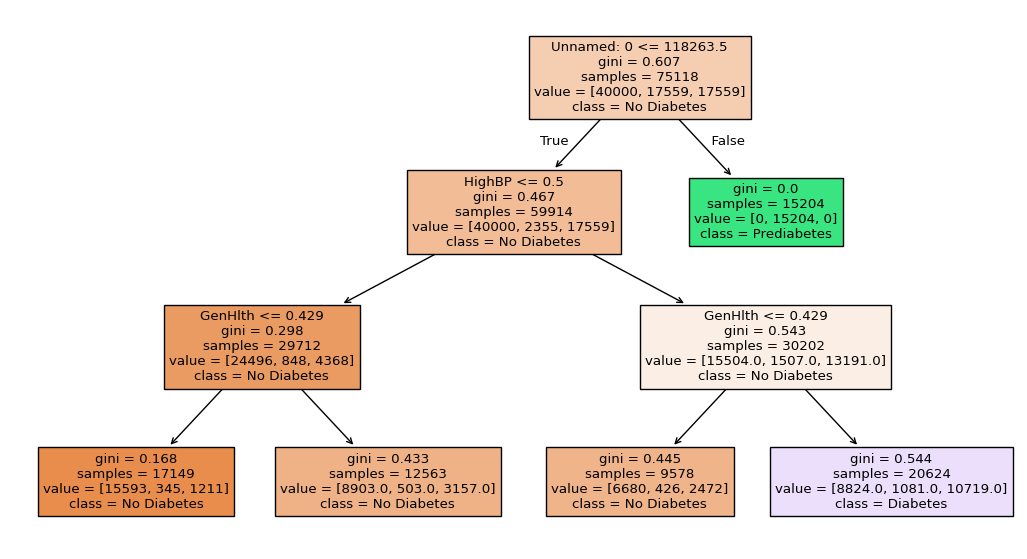

In [ ]:
def load_dataset(csv_path):
    df=pd.read_csv(csv_path)
    x=df.drop(columns=["Diabetes_012"]).values
    y=df["Diabetes_012"].values  
    return x,y,df.columns[:-1].tolist()

dt_model=DT(max_depth=5,min_samples_split=2,device="cuda")

csv_path="cleaned.csv"  
x,y,feature_names=load_dataset(csv_path)
x_torch=torch.tensor(x,dtype=torch.float32,device=dt_model.device)
y_torch=torch.tensor(y,dtype=torch.int64,device=dt_model.device)

dt_model.tree=dt_model.build_tree(x_torch, y_torch)
predictions=dt_model.predict(x)
print("Predictions:",predictions.cpu().numpy())

def plot_sklearn_tree(x,y,feature_names):
    clf=DecisionTreeClassifier(max_depth=3)
    clf.fit(x,y)
    plt.figure(figsize=(13, 7))
    plot_tree(clf,feature_names=feature_names,class_names=["No Diabetes","Prediabetes","Diabetes"],filled=True)
    plt.show()

plot_sklearn_tree(x,y,feature_names)


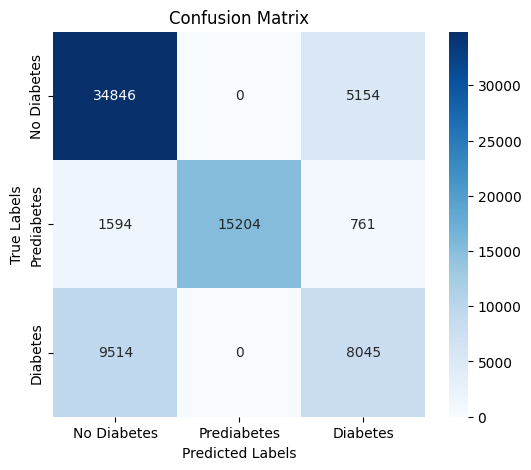


Classification Report:
               precision    recall  f1-score   support

 No Diabetes       0.76      0.87      0.81     40000
 Prediabetes       1.00      0.87      0.93     17559
    Diabetes       0.58      0.46      0.51     17559

    accuracy                           0.77     75118
   macro avg       0.78      0.73      0.75     75118
weighted avg       0.77      0.77      0.77     75118



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = predictions.cpu().numpy()
y_true = y_torch.cpu().numpy()

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Diabetes", "Prediabetes", "Diabetes"], 
            yticklabels=["No Diabetes", "Prediabetes", "Diabetes"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

class_report = classification_report(y_true, y_pred, target_names=["No Diabetes","Prediabetes","Diabetes"])
print("\nClassification Report:\n", class_report)


C:\Users\charu\AppData\Local\Temp\ipykernel_16868\3092271769.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_torch = torch.tensor(x_train, dtype=torch.float32, device=self.device)
C:\Users\charu\AppData\Local\Temp\ipykernel_16868\3092271769.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_torch = torch.tensor(y_train, dtype=torch.int64, device=self.device)
C:\Users\charu\AppData\Local\Temp\ipykernel_16868\3092271769.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_torch=torch.tensor(x,dtype=torch.float32,dev

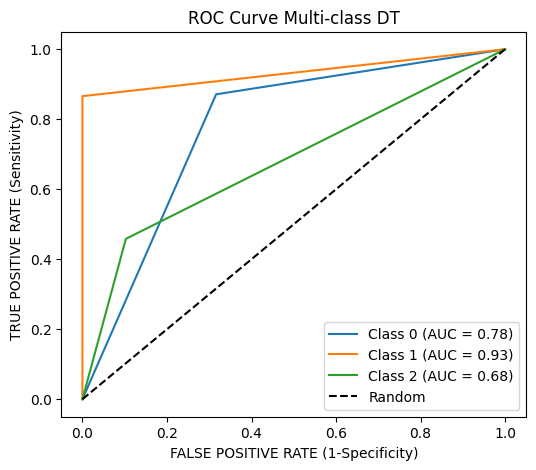

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

def plot_roc_curve(y_test,y_prob,classes=[0,1,2]):
    y_test_bin=label_binarize(y_test, classes=classes)    
    plt.figure(figsize=(6, 5))

    for i in range(len(classes)):
        fpr,tpr,_=roc_curve(y_test_bin[:,i],y_prob[:,i])
        roc_auc=auc(fpr, tpr)
        plt.plot(fpr,tpr,label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0,1],[0,1],'k--',label='Random')

    plt.xlabel('FALSE POSITIVE RATE (1-Specificity)')
    plt.ylabel('TRUE POSITIVE RATE (Sensitivity)')
    plt.title('ROC Curve Multi-class DT')
    plt.legend(loc='lower right')
    plt.show()

best_dt=DT(max_depth=5)  
best_dt.fit(x_torch,y_torch)
y_prob=best_dt.predict_proba(x_torch)
plot_roc_curve(y_true, y_prob)
